# DRAGAN
## GAN

$$L_D^{GAN} = E[log(D(x))] + E[log(1 - D(G(z))]$$

$$L_G^{GAN} = E[log(D(G(z)))]$$

## DRAGAN
$$L_D^{DRAGAN} = L_D^{GAN} + \lambda E [(|\nabla D(\alpha x - (1 - \alpha x_p)) | - 1)^2]$$

$$L_G^{DRAGAN} = L_G^{GAN}$$

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable, grad
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid

import gzip
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Setting hyperparameters

In [2]:
num_epochs = 30
learning_rate = 0.0002
batch_size = 64
z_dim = 62
sample_num = 64
beta1 = 0.5
beta2 = 0.999
# c = 0.01
lambda_ = 0.25

result_dir = './save_results/MNIST/DRAGAN'
model_dir = './save_models/MNIST/DRAGAN'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## 3. Load dataset

In [3]:
def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)
    
    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

In [4]:
data_X, data_Y = load_mnist("MNIST")

print(data_X.size())
print(data_X.__getitem__(11).size())

torch.Size([70000, 1, 28, 28])
torch.Size([1, 28, 28])


## 4. Build Models
### 4.1 Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Generator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid()
        )
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

### 4.2 Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid()
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)
        return x

## util

In [7]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['d_loss']))

    y1 = hist['d_loss']
    y2 = hist['g_loss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

## 5. Models & Loss func
- BCE Loss

In [8]:
G = Generator(28, 28, z_dim, 1)
D = Discriminator(28, 28, 1, 1)
G.initialize_weights()
D.initialize_weights()

sample_z = torch.randn((batch_size, z_dim), requires_grad=False)

g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))

BCE_loss = nn.BCELoss()

if USE_CUDA:
    G = G.cuda()
    D = D.cuda()
    sample_z = sample_z.cuda()

## 5. Load Models

In [9]:
try:
    G.load_state_dict(torch.load(model_dir + '/dragan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/dragan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



In [10]:
print(G)
print(D)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

## 6. Train

$$L_D^{DRAGAN} = L_D^{GAN} + \lambda E [(|\nabla D(\alpha x - (1 - \alpha x_p)) | - 1)^2]$$

$$L_G^{DRAGAN} = L_G^{GAN}$$


In [11]:
train_hist = {}
train_hist['d_loss'] = []
train_hist['g_loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []

real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

if USE_CUDA:
    real_labels =  real_labels.cuda()
    fake_labels = fake_labels.cuda()

In [12]:
D.train()
print("training start!!")
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    G.train()
    
    for iter in range(len(data_X) // batch_size):
        images = data_X[iter*batch_size:(iter+1)*batch_size]
    
        z = torch.rand((batch_size, z_dim))

        if USE_CUDA:
            images = images.cuda() 
            z = z.cuda()
        
        # update D network
        d_optimizer.zero_grad()
        
        d_real = D(images)
        d_loss_real = BCE_loss(d_real, real_labels)
        
        fake_images = G(z)
        d_fake = D(fake_images)
        d_loss_fake = BCE_loss(d_fake, fake_labels)
        
        if USE_CUDA:
            alpha = torch.rand(images.size()).cuda()
            x_hat = Variable(alpha * images.data + (1 - alpha) * (images.data + 0.5 * images.data.std() * torch.rand(images.size()).cuda()), requires_grad=True)
        else:
            alpha = torch.rand(x_.size())
            x_hat = Variable(alpha * images.data + (1 - alpha) * (images.data + 0.5 * images.data.std() * torch.rand(images.size())), requires_grad=True)
        
        pred_hat = D(x_hat)
        
        if USE_CUDA:
            gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(), create_graph=True, retain_graph=True, only_inputs=True)[0]
        else:
            gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()), create_graph=True, retain_graph=True, only_inputs=True)[0]
        
        gradient_penalty = lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()
        
        d_loss = d_loss_real + d_loss_fake + gradient_penalty
        
        train_hist['d_loss'].append(d_loss.item())
        d_loss.backward()
        d_optimizer.step()
        
        # Update G network
        g_optimizer.zero_grad()
        
        fake_images = G(z)
        d_fake = D(fake_images)
        
        g_loss = BCE_loss(d_fake, real_labels)
        train_hist['g_loss'].append(g_loss.item())
        
        g_loss.backward()
        g_optimizer.step()
        if ((iter + 1) % 100) == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                  %(epoch, num_epochs, (iter + 1), len(data_X) // batch_size, d_loss.item(), g_loss.item()))
            
    train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
    
    # Save
    G.eval()

    # Save sample images
    samples = G(sample_z)
    generated_sample = samples.view(sample_num, 1, 28, 28)
    save_image(generated_sample.data, result_dir + '/generated_images-%d.png'%(epoch + 1))
    
train_hist['total_time'].append(time.time() - start_time)
print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']), num_epochs, train_hist['total_time'][0]))

torch.save(G.state_dict(), model_dir + '/dragan_generator.pkl')
torch.save(D.state_dict(), model_dir + '/dragan_discriminator.pkl')

loss_plot(train_hist, result_dir, 'DRAGAN')

training start!!
Epoch [1/30], Step [100/1093], D_loss: 1.3412, G_loss: 0.9002
Epoch [1/30], Step [200/1093], D_loss: 1.0345, G_loss: 1.1871
Epoch [1/30], Step [300/1093], D_loss: 0.7273, G_loss: 1.4088
Epoch [1/30], Step [400/1093], D_loss: 0.6092, G_loss: 1.5962
Epoch [1/30], Step [500/1093], D_loss: 0.5080, G_loss: 1.7906
Epoch [1/30], Step [600/1093], D_loss: 0.4403, G_loss: 1.8918
Epoch [1/30], Step [700/1093], D_loss: 0.6954, G_loss: 1.9780
Epoch [1/30], Step [800/1093], D_loss: 0.7502, G_loss: 1.0714
Epoch [1/30], Step [900/1093], D_loss: 1.0472, G_loss: 1.2870
Epoch [1/30], Step [1000/1093], D_loss: 1.1277, G_loss: 1.4841
Epoch [2/30], Step [100/1093], D_loss: 0.9672, G_loss: 1.2955
Epoch [2/30], Step [200/1093], D_loss: 0.9060, G_loss: 1.2798
Epoch [2/30], Step [300/1093], D_loss: 0.9304, G_loss: 1.2333
Epoch [2/30], Step [400/1093], D_loss: 0.8409, G_loss: 1.2984
Epoch [2/30], Step [500/1093], D_loss: 0.9178, G_loss: 1.1320
Epoch [2/30], Step [600/1093], D_loss: 1.1269, G_los

Epoch [14/30], Step [200/1093], D_loss: 0.6959, G_loss: 1.9227
Epoch [14/30], Step [300/1093], D_loss: 0.7002, G_loss: 1.9271
Epoch [14/30], Step [400/1093], D_loss: 0.7815, G_loss: 2.2411
Epoch [14/30], Step [500/1093], D_loss: 0.5709, G_loss: 2.0246
Epoch [14/30], Step [600/1093], D_loss: 0.8534, G_loss: 2.2498
Epoch [14/30], Step [700/1093], D_loss: 0.6131, G_loss: 1.8392
Epoch [14/30], Step [800/1093], D_loss: 0.8404, G_loss: 1.1673
Epoch [14/30], Step [900/1093], D_loss: 0.6154, G_loss: 1.7912
Epoch [14/30], Step [1000/1093], D_loss: 0.6968, G_loss: 2.0526
Epoch [15/30], Step [100/1093], D_loss: 0.6496, G_loss: 1.7715
Epoch [15/30], Step [200/1093], D_loss: 0.9888, G_loss: 1.7487
Epoch [15/30], Step [300/1093], D_loss: 0.7503, G_loss: 1.5765
Epoch [15/30], Step [400/1093], D_loss: 0.6909, G_loss: 1.9774
Epoch [15/30], Step [500/1093], D_loss: 0.6516, G_loss: 1.6564
Epoch [15/30], Step [600/1093], D_loss: 0.6444, G_loss: 2.1014
Epoch [15/30], Step [700/1093], D_loss: 0.6053, G_loss

Epoch [27/30], Step [200/1093], D_loss: 0.5187, G_loss: 2.0646
Epoch [27/30], Step [300/1093], D_loss: 0.4248, G_loss: 2.6755
Epoch [27/30], Step [400/1093], D_loss: 0.5549, G_loss: 3.1510
Epoch [27/30], Step [500/1093], D_loss: 0.5593, G_loss: 2.5781
Epoch [27/30], Step [600/1093], D_loss: 0.4493, G_loss: 2.1418
Epoch [27/30], Step [700/1093], D_loss: 0.5309, G_loss: 2.3002
Epoch [27/30], Step [800/1093], D_loss: 0.4028, G_loss: 2.3429
Epoch [27/30], Step [900/1093], D_loss: 0.3712, G_loss: 2.8081
Epoch [27/30], Step [1000/1093], D_loss: 0.4437, G_loss: 2.7563
Epoch [28/30], Step [100/1093], D_loss: 0.7588, G_loss: 2.0009
Epoch [28/30], Step [200/1093], D_loss: 0.5238, G_loss: 2.7018
Epoch [28/30], Step [300/1093], D_loss: 0.7751, G_loss: 1.9391
Epoch [28/30], Step [400/1093], D_loss: 0.3569, G_loss: 2.8839
Epoch [28/30], Step [500/1093], D_loss: 0.8356, G_loss: 1.0981
Epoch [28/30], Step [600/1093], D_loss: 0.4950, G_loss: 2.5427
Epoch [28/30], Step [700/1093], D_loss: 0.3707, G_loss

## 7. Display generated data

In [13]:
import imageio

images = []
for epoch in range(num_epochs + 1):
    try:
        img_name = result_dir + '/generated_images-%d.png'%(epoch + 1)
        images.append(imageio.imread(img_name))
    except:
        pass
    
imageio.mimsave(result_dir + '/fake_images_total.gif', images, fps=4)


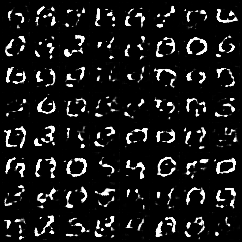

In [14]:
import io
import base64
from IPython.display import HTML

video = io.open(result_dir + '/fake_images_total.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## 8. Use models to generate new sample

In [15]:
try:
    G.load_state_dict(torch.load(model_dir + '/dragan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/dragan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



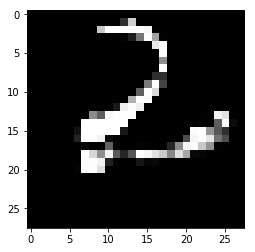

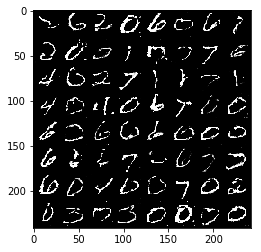

In [16]:
z = torch.randn(sample_num, z_dim)

if USE_CUDA:
    z = z.cuda()
    
G.eval()
fake_images = G(z)
plt.imshow(fake_images[2].cpu().view(28, 28).data.numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(fake_images.data.view(sample_num,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()